In [36]:
import pandas as pd
import os
import shutil
from zipfile import ZipFile, BadZipFile
import json
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from sklearn.cluster import KMeans


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

print(np.__version__)

1.26.4


In [37]:
def check_gpu():
    if torch.cuda.is_available():
        print("CUDA está disponible.")
        print(f"Hay {torch.cuda.device_count()} GPU(s) disponible(s).")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA no está disponible. No hay GPU accesible.")

check_gpu()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA está disponible.
Hay 1 GPU(s) disponible(s).
GPU 0: NVIDIA GeForce RTX 2060


## IMPORT AND PREPROCESS DATA (scripts list)

In [38]:
metrics = pd.read_csv('metrics_attr.csv')

# Filter by Action Genre
metrics_action = metrics[(metrics['Main Genre'] == 'Action')]

# Check the filenames for collect
filenames_action = list(metrics_action['Name'])

In [39]:
def load_json_project(path_projectsb3):
    try:
        zip_file = ZipFile(path_projectsb3, "r")
        json_project = json.loads(zip_file.open("project.json").read())
        return json_project
    except BadZipFile:
        print('Bad zipfile')

def process(json_project):
    seq_num = 0
    dict_total_blocks = {}
    
    list_total_blocks = []

    for key, list_info in json_project.items():
        if key == "targets":
            for dict_target in list_info:
                target_name = dict_target.get('name')
                if target_name:
                    dict_total_blocks[target_name] = {}
                    dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                blocks = dict_target.get('blocks')
                if blocks:
                    for block_id, block_info in blocks.items():
                        if isinstance(block_info, dict):
                            topLevel = block_info.get('topLevel')
                            if topLevel:
                                seq_num += 1
                                dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                            opcode = block_info.get('opcode')
                            if opcode:
                                
                                dict_total_blocks[target_name][f'Seq_{seq_num}'].append(opcode)
                            list_total_blocks.append(block_info)
                            #dict_total_blocks[block_id] = block_info
    return dict_total_blocks

dict_total_blocks = {}
scripts = []
list_total_blocks = []
print(len(filenames_action))
for project in filenames_action:
    sb3_path = os.path.join('.','sb3_action_global',project)
    if os.path.isfile(sb3_path):
        print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            for idx, block_list in seqs.items():
                if block_list != []:
                    scripts.append(" ".join(block_list))

#print(dict_total_blocks)
for script in scripts:
    print(script + '\n')

312
Abby and Grace's project.sb3
Adventures of TreeGuy.sb3
Ahmet-Ofer.sb3
Aji Jesu Game.sb3
Albedo Barrier.sb3
Albedo Pong.sb3
Albedo Project.sb3
Alex and Hannah's project.sb3
Aman and Brady Project.sb3
Anjali and Mariana-3.sb3
Artem Tsukasa.sb3
Atmosphere Pong.sb3
Avery's Life.sb3
Beat the Robot.sb3
Becca and Alana Climate change.sb3
Become the Best Lumberjack.sb3
Brendan and Hallel.sb3
Brick Breaker remix.sb3
Bryan and Mark's Game Project.sb3
Building wackamole in the city of Hainsboro.sb3
CARbon Killer.sb3
CAUSATION EVASION.sb3
CO2 Crusher.sb3
CO2 Drop.sb3
CO2 Footprints.sb3
CO2 Killer.sb3
CO2 Stopper Copter.sb3
CO2 Stopper.sb3
CO2 destroyer.sb3
CO2 fr.sb3
CO2 journey.sb3
Car Bike Atmosphere.sb3
Car Game.sb3
Car.sb3
Carbon Annihilation.sb3
Carbon Capture.sb3
Carbon Clicker_(2).sb3
Carbon Destroyer.sb3
Carbon Footprint project.sb3
Carbon Game by Ria and Sarah.sb3
Carbon Game.sb3
Carbon Maze.sb3
Carbon Run.sb3
Carbon Run_(2).sb3
Cars and co2.sb3
Catch the CO2.sb3
Clara and Mira's Proj

## CREATION OF DATASET

In [40]:
class SkipGramData(Dataset):
    def __init__(self, corpus, window_sz= 4):
        super().__init__
        self.corpus = corpus
        self.window = window_sz
        self.vocab = list(set(token.lower() for sentence in self.corpus for token in sentence.split())) # set elimina dups y no mantiene el orden
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.data = self.gen_dataset()

    def gen_dataset(self):
        # Metod for enventanado
        data = []
        for sentence in self.corpus:
            text = sentence.lower().split()
            #print(text)
            for center_idx, center_word in enumerate(text):
                for offset in range(-self.window, self.window +1):
                    context_idx = center_idx + offset
                    if context_idx < 0 or context_idx >= len(text) or context_idx == center_idx: continue
                    context_word = text[context_idx]
                    data.append((self.word2idx[center_word], self.word2idx[context_word]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [41]:
def train_skipgram(model, loss_function, optimizer, data_loader, epochs=100):
    model.train() 
    for epoch in range(epochs):
        total_loss = 0
        for center, context in data_loader:
            center, context = center.to(device), context.to(device)
            
            center_vector = torch.zeros(len(data_loader.dataset.vocab), device=device) 
            center_vector[center] = 1.0
            center_vector = center_vector.unsqueeze(0)  

            scores = model(center_vector)
            
            labels = torch.tensor([context], dtype=torch.long, device=device)
            loss = loss_function(scores, labels)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.synchronize() 
            
            # Acumulando la pérdida
            total_loss += loss.item()
        
        # Imprimir la pérdida media por epoch
        print(f'Epoch: {epoch+1}, Loss: {total_loss/len(data_loader)}')

## DEFINE ARCHITECTURE AND IMPORT MODEL 

In [42]:
class SkipGram(nn.Module):
    def __init__(self, vocab_sz, embed_sz):
        super().__init__()
        self.embed_layer = nn.Linear(vocab_sz, embed_sz, bias = False)
        self.output_layer = nn.Linear(embed_sz, vocab_sz)

    def forward(self, x):
        return self.output_layer(self.embed_layer(x))

In [43]:
learning_rate = 0.0001

dataset = SkipGramData(scripts)
print(type(dataset.data))
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = SkipGram(len(dataset.vocab), embed_sz=300)
model.load_state_dict(torch.load('embedding_action_global_wsz4.pth')['model_state_dict'])
model.eval()

embeddings = model.embed_layer.weight.detach().numpy()
print("Embed_layer weights:", embeddings)


<class 'list'>
Embed_layer weights: [[ 1.5259806e+00  3.4318283e-01 -2.8420371e-01 ... -9.3231887e-02
  -5.5682415e-01 -3.4779424e-04]
 [ 1.9055022e-01 -1.7587899e-01 -7.2846167e-02 ... -1.9412635e-02
  -2.0346090e-01  6.8490557e-02]
 [-9.2278075e-01 -5.7349674e-02  1.2761180e-01 ... -5.7013612e-02
  -8.9237593e-02  2.2793905e-01]
 ...
 [ 5.2254224e-01  6.1818957e-01 -6.7205518e-02 ... -1.5180361e-01
   7.9570270e-01 -5.6492239e-03]
 [ 6.8440162e-02 -2.4512310e-01  1.9911183e-01 ...  9.7805351e-02
   1.7358449e-01  1.4208922e-01]
 [-8.2199484e-01  2.9267550e-01  1.1666592e-01 ...  1.9012672e-01
   8.3276832e-01  2.0963660e-01]]


## PLOTING RESULTS

In [44]:
def plot_embeddings(embedings, word2idx):
    num_samples = len(word2idx)
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)
    plt.figure(figsize=(30,20))
    for word, idx in word2idx.items():
        plt.scatter(vectors[idx, 0], vectors[idx, 1])
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), xytext=(5,2), 
                    textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embeddings Visualized using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel(True)
    plt.show()
    plt.savefig('embedding_action_clicker.png', format='png')

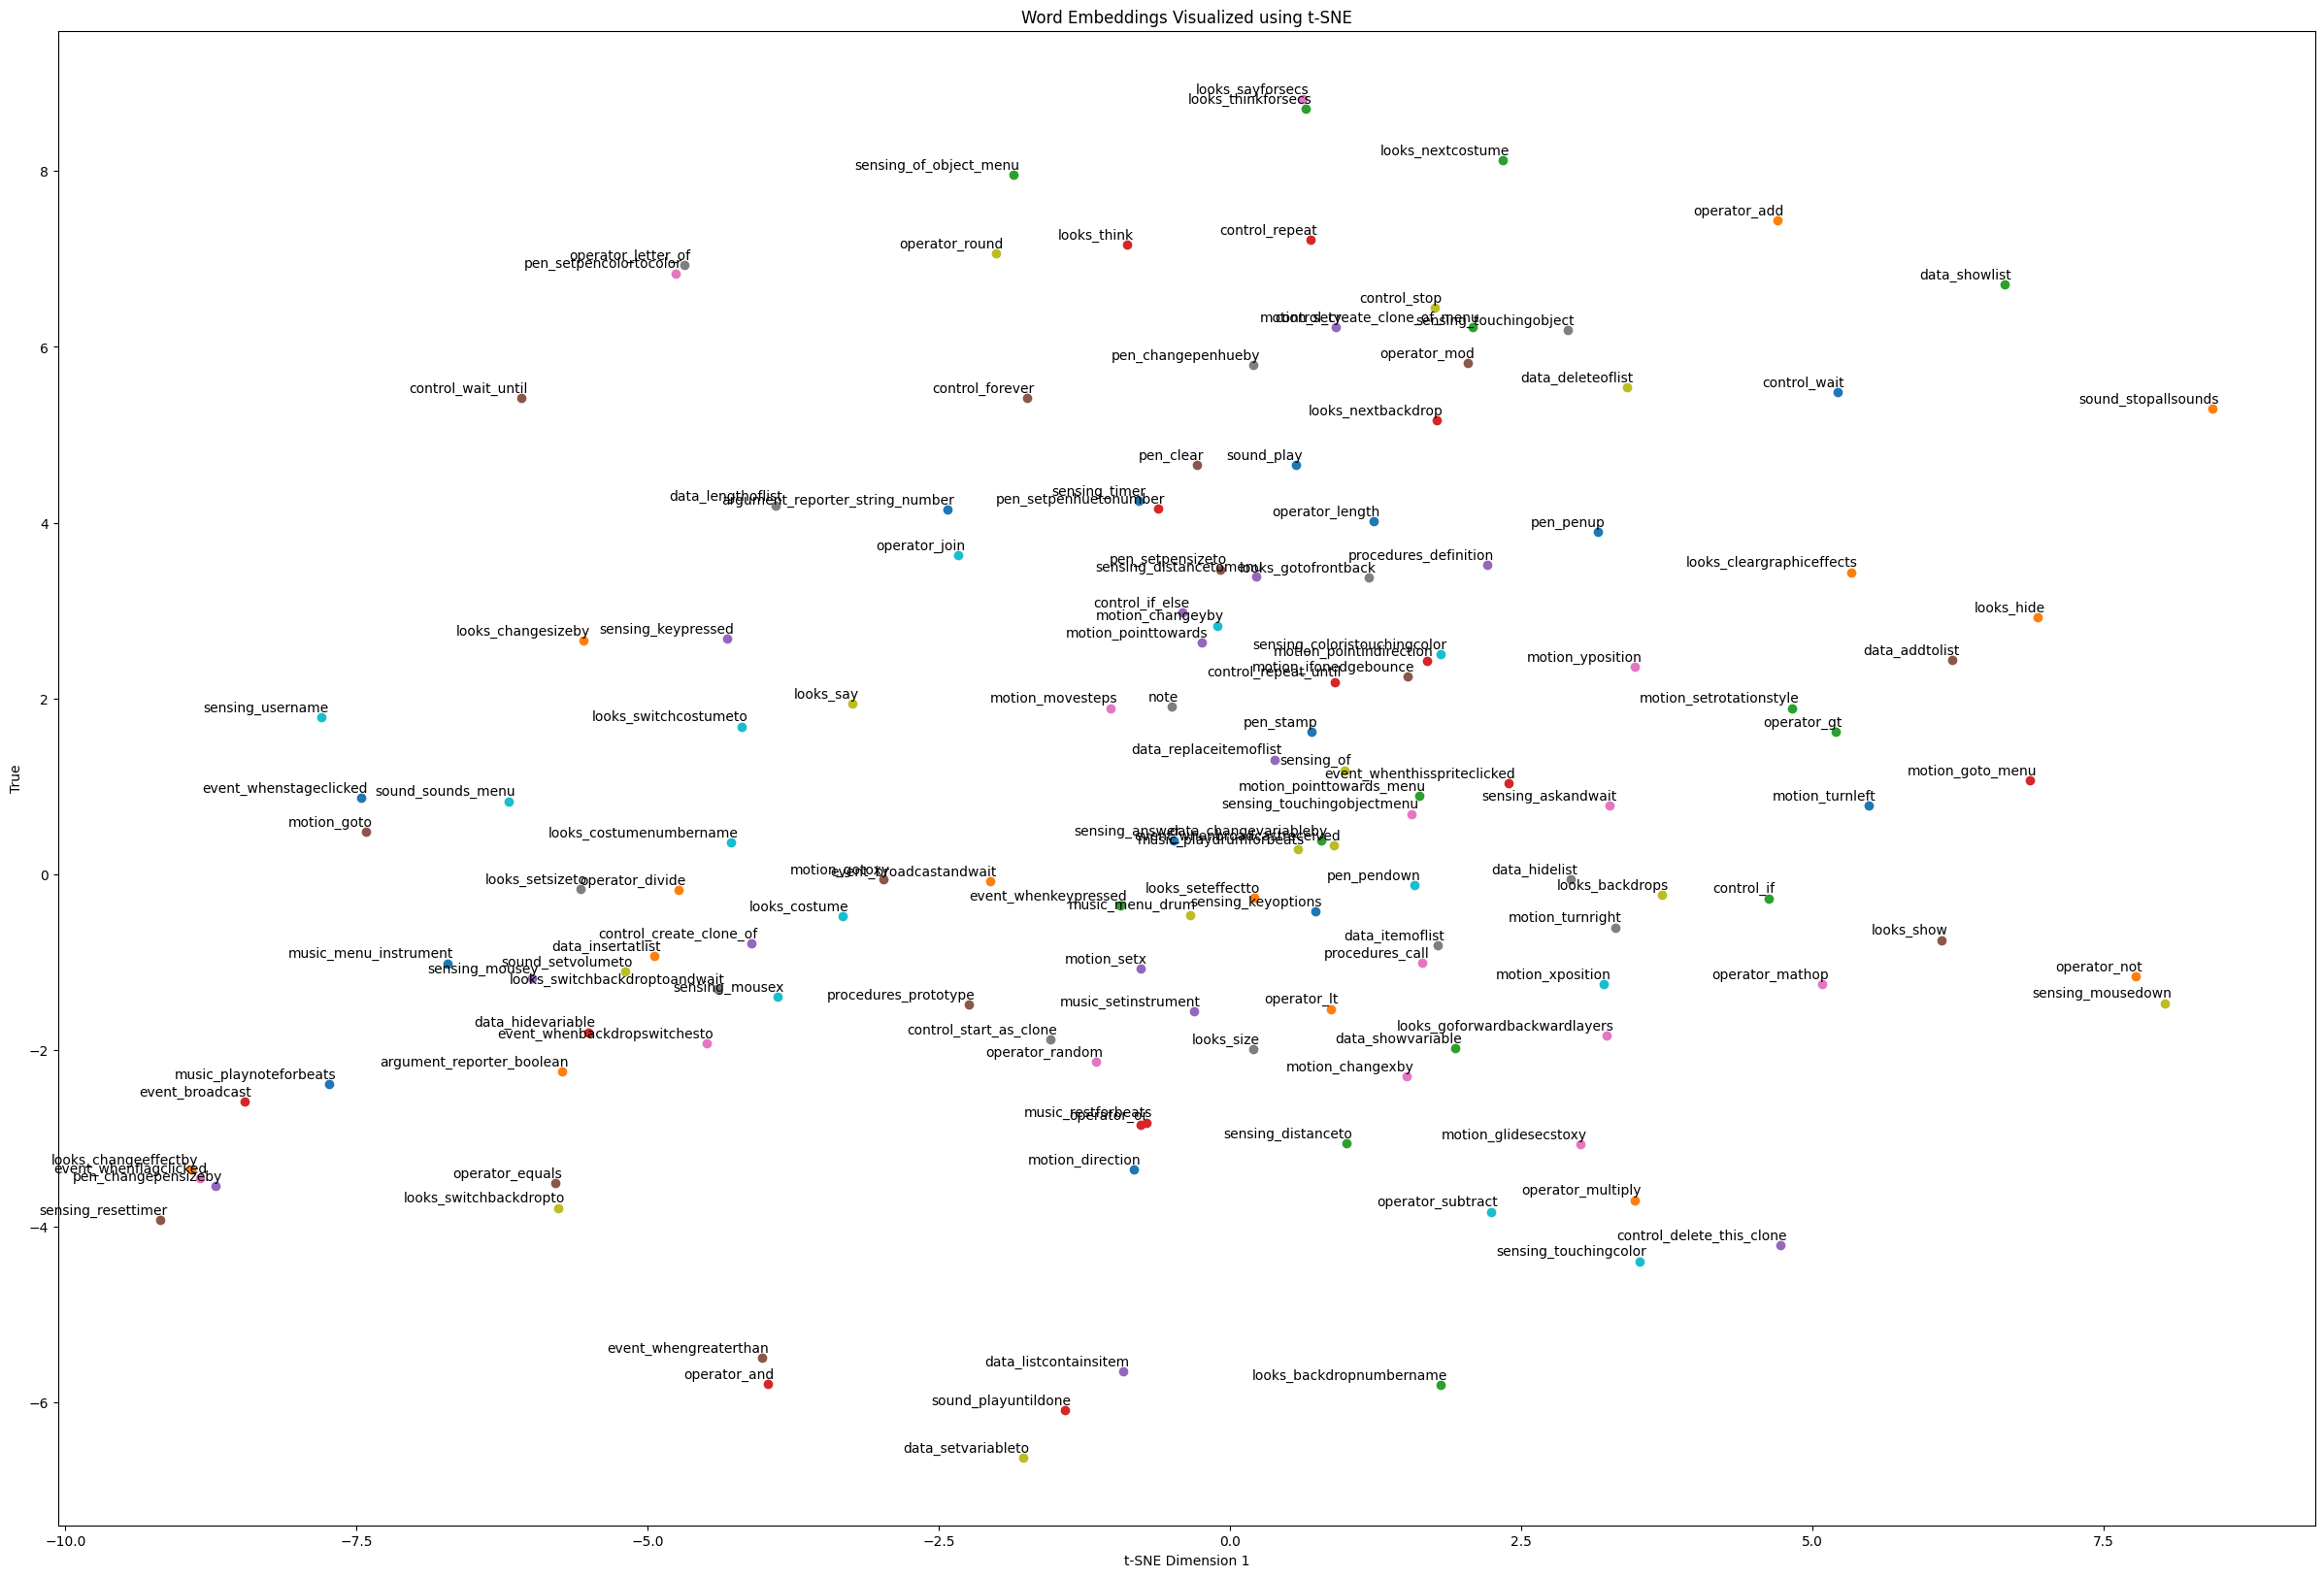

<Figure size 640x480 with 0 Axes>

In [45]:
embeddings = model.embed_layer.weight.detach().cpu().numpy()
plot_embeddings(embeddings, dataset.word2idx)

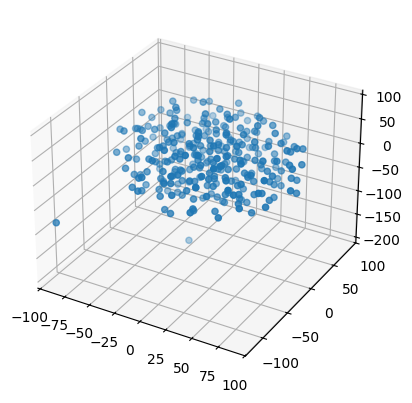

In [46]:
tsne = TSNE(n_components=3)
embeddings_3d = tsne.fit_transform(embeddings)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])
plt.show()

In [47]:
import plotly.express as px
import pandas as pd

# Suponiendo que tus embeddings están en la variable `embeddings`
df = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'])
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

## K-Means

In [48]:
from sklearn.preprocessing import normalize, StandardScaler

# Because of the nature of the embeddings we have to normalize these before apply clutering
normalized_embeddings = normalize(embeddings, norm='l2')

scaler = StandardScaler()

X_standardized = scaler.fit_transform(normalized_embeddings)

print(X_standardized)

[[ 2.9536035   1.1316897  -1.8612365  ... -0.49179274 -1.0608054
  -0.0965344 ]
 [ 0.32259625 -0.4269445  -0.37548265 ... -0.07894323 -0.3262986
   0.14619578]
 [-1.5661522  -0.1403422   0.76613575 ... -0.2699984  -0.1729074
   0.8106884 ]
 ...
 [ 1.2581086   2.4682646  -0.534088   ... -0.9857415   1.7969143
  -0.12548621]
 [ 0.2175484  -1.1004096   1.8775171  ...  0.74553645  0.43934977
   0.7973139 ]
 [-1.4675905   0.9231517   0.7380571  ...  0.964773    1.4544368
   0.78236926]]


In [49]:

k_values = range(1, 11)
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_standardized)
    wcss.append(kmeans.inertia_)  

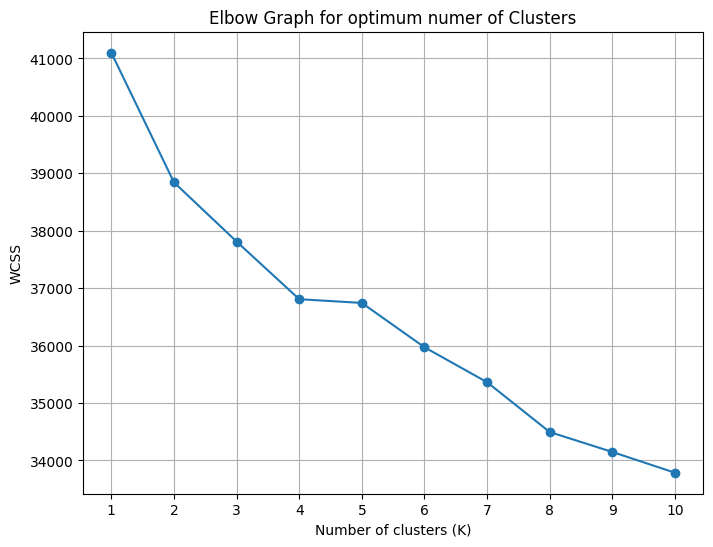

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Graph for optimum numer of Clusters')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [51]:
elbow_graph = {}
for idx, k in enumerate(k_values):
    elbow_graph[k] = wcss[idx]

In [52]:
print(elbow_graph)

{1: 41100.00390625, 2: 38842.83984375, 3: 37811.88671875, 4: 36808.4140625, 5: 36743.1484375, 6: 35971.80078125, 7: 35362.5703125, 8: 34495.33984375, 9: 34148.23046875, 10: 33786.8984375}


In [53]:


# I have selected k=5 clusters with the elbow graph
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_standardized)

# For each coordinate of points of embeddings we have a label for each one
labels = kmeans.labels_
print("Labels:", labels)

# Also we have the points
centroids = kmeans.cluster_centers_
print("Centroids:", centroids)

Labels: [2 2 1 2 1 3 0 2 0 2 1 2 3 0 0 3 2 1 1 1 3 0 0 3 3 1 2 1 1 1 1 0 0 2 2 2 1
 3 1 1 3 0 0 0 0 3 1 2 0 3 2 2 1 2 0 3 1 0 2 3 2 0 0 2 2 2 0 2 1 1 2 3 2 2
 3 3 2 3 3 1 0 1 2 2 0 2 2 2 3 3 2 2 0 3 3 0 1 2 2 2 1 2 0 1 2 1 0 3 3 0 3
 3 1 1 2 2 2 1 0 2 2 1 3 0 1 0 2 0 2 2 1 2 1 0 3 0 1 1 2 3 2 3 2 1 2 2 0 0
 3 2 3 1 0 0 0 0 0 0 0 1 2 2 2 3 0 0 2 2 2 3 1 2 0 3 0 2 1 2 2 1 3 3 0 1 0
 1 2 3 3 3 3 1 1 1 2 1 0 2 3 2 3 0 3 3 3 1 3 2 3 0 1 1 2 3 3 1 3 0 3 0 1 2
 2 1 3 2 0 3 2 2 2 2 1 1 2 0 1 2 2 3 3 2 0 3 3 0 2 2 1 3 1 0 2 3 1 3 1 2 3
 2 3 1 2 1 3 1 3 2 2 2 1 0 3 1 2 3 2 1 0 2 2 0 2 1 2 0 1 2 2 3 2 2 2 1 1 0
 2 2 1 2]
Centroids: [[-1.61733225e-01 -2.74339795e-01  2.68833727e-01 -1.90841794e-01
   2.62861788e-01 -8.03694129e-03  2.63307780e-01 -1.70038968e-01
  -1.91475973e-01  3.06393504e-01  2.88978845e-01 -2.86934167e-01
  -1.76225290e-01 -3.13376278e-01 -6.85611188e-01 -1.81949049e-01
   1.46150123e-03 -1.35650709e-01 -3.76605941e-03 -1.38938665e-01
  -6.49673700e-01 -1.55555859e-01  2.8679

### Evaluation of the cluster

In [54]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(embeddings, labels)
print(f'Índice de Silueta: {silhouette_avg}')

Índice de Silueta: 0.025490235537290573


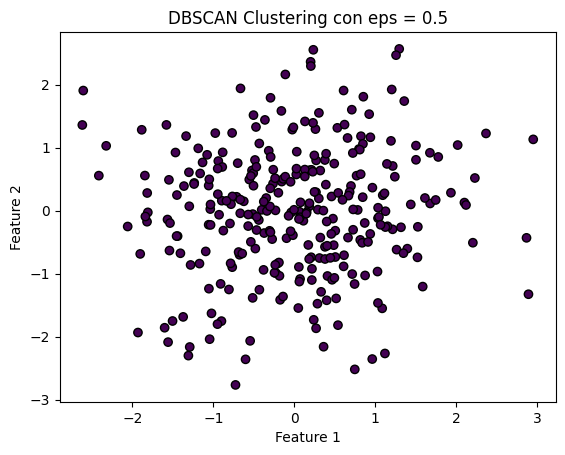

In [55]:
from sklearn.cluster import DBSCAN


eps = 0.5  # Reemplaza con el valor obtenido del gráfico
min_samples = 5  # Ajusta según tus necesidades

# Ejecuta DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_standardized)

# Verifica los resultados
plt.scatter(X_standardized[:, 0], X_standardized[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering con eps = {}'.format(eps))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Ajustar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_standardized)
labels = dbscan.labels_

# Comprobar si hay más de un cluster
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
if num_clusters > 1:
    silhouette_avg = silhouette_score(X_standardized, labels)
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print('DBSCAN no encontró múltiples clusters')


DBSCAN no encontró múltiples clusters


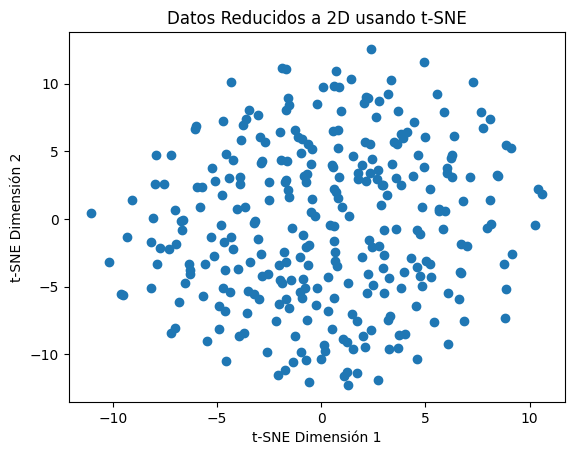

Silhouette Score for KMeans: 0.35368260741233826


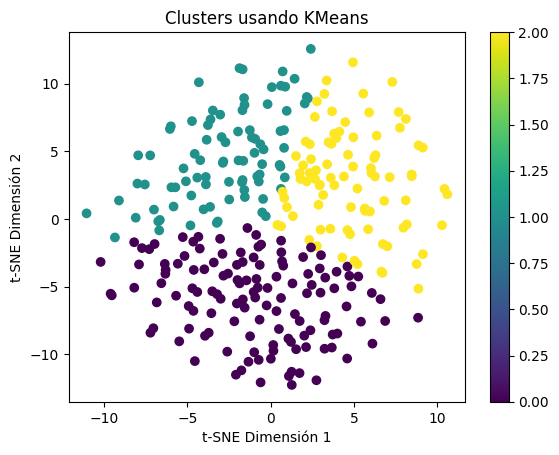

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Reducir dimensionalidad a 2D usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_standardized)

# Visualizar los datos reducidos
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('Datos Reducidos a 2D usando t-SNE')
plt.xlabel('t-SNE Dimensión 1')
plt.ylabel('t-SNE Dimensión 2')
plt.show()


# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=0)  # Ajusta n_clusters según tus necesidades
labels_kmeans = kmeans.fit_predict(X_tsne)  # Usa X_pca si prefieres PCA

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_tsne, labels_kmeans)
print(f'Silhouette Score for KMeans: {silhouette_avg}')

# Visualizar clusters
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_kmeans, cmap='viridis')
plt.title('Clusters usando KMeans')
plt.xlabel('t-SNE Dimensión 1')
plt.ylabel('t-SNE Dimensión 2')
plt.colorbar()
plt.show()

DBSCAN no encontró múltiples clusters


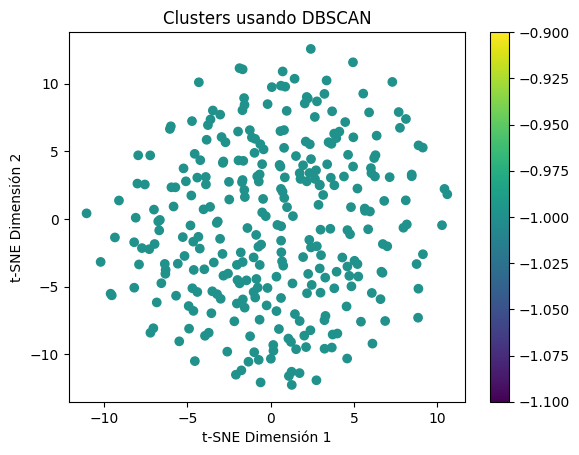

In [58]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajusta eps y min_samples según tus necesidades
labels_dbscan = dbscan.fit_predict(X_tsne)  # Usa X_pca si prefieres PCA

# Verificar el número de clusters
num_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
if num_clusters_dbscan > 1:
    silhouette_avg_dbscan = silhouette_score(X_tsne, labels_dbscan)
    print(f'Silhouette Score for DBSCAN: {silhouette_avg_dbscan}')
else:
    print('DBSCAN no encontró múltiples clusters')

# Visualizar clusters
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_dbscan, cmap='viridis')
plt.title('Clusters usando DBSCAN')
plt.xlabel('t-SNE Dimensión 1')
plt.ylabel('t-SNE Dimensión 2')
plt.colorbar()
plt.show()

## TEST WITH RANDOM ACTION PROJECT

In [59]:
sb3_project = os.path.join("./Beat the Robot.sb3")

dict_total_blocks = {}
scripts_test = []
list_total_blocks = []

if os.path.isfile(sb3_project):
    print(project)
    json_project = load_json_project(sb3_project)
    dict_total_blocks = process(json_project)

    for sprite, seqs in dict_total_blocks.items():
        for idx, block_list in seqs.items():
            if block_list != []:
                scripts_test.append(" ".join(block_list))

#print(dict_total_blocks)
print(len(scripts_test))
for script in scripts_test:
    print(script + '\n')


welknkmCX 'lkSD ow EVIw oP iwb'lkNSFPVON.sb3
24
event_whenflagclicked looks_switchbackdropto looks_backdrops

event_whenflagclicked sound_play sound_sounds_menu

event_whenbackdropswitchesto sound_stopallsounds

event_whenbackdropswitchesto

event_whenkeypressed motion_changeyby

event_whenkeypressed motion_changeyby

event_whenkeypressed motion_movesteps

event_whenkeypressed motion_changexby

event_whenbackdropswitchesto motion_gotoxy operator_random

event_whenflagclicked control_forever control_wait_until sensing_touchingobject sensing_touchingobjectmenu motion_gotoxy

event_whenflagclicked looks_show motion_gotoxy control_forever control_wait_until sensing_touchingobject sensing_touchingobjectmenu looks_switchbackdropto looks_backdrops looks_hide

event_whenflagclicked control_forever data_setvariableto sensing_timer

event_whenbackdropswitchesto looks_hide

event_whenkeypressed motion_changeyby

event_whenkeypressed motion_movesteps

event_whenkeypressed motion_movesteps

event_w

In [63]:
def train_skipgram_test(model, loss_function, optimizer, data_loader, data_loader_test,epochs=100):
    model.train() 
    for epoch in range(epochs):
        total_loss = 0
        for center, context in data_loader_test:
            center, context = center.to(device), context.to(device)
            
            center_vector = torch.zeros(len(data_loader.dataset.vocab), device=device) 
            center_vector[center] = 1.0
            center_vector = center_vector.unsqueeze(0)  

            scores = model(center_vector)
            
            labels = torch.tensor([context], dtype=torch.long, device=device)
            loss = loss_function(scores, labels)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.synchronize() 
            
            # Acumulando la pérdida
            total_loss += loss.item()
        
        # Imprimir la pérdida media por epoch
        print(f'Epoch: {epoch+1}, Loss: {total_loss/len(data_loader)}')

In [65]:
learning_rate = 0.0001

dataset_test = SkipGramData(scripts_test)
print(type(dataset.data))
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)
model_test = SkipGram(len(dataset.vocab), embed_sz=300).to(device)
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
loss_function = nn.CrossEntropyLoss()

train_skipgram_test(model_test, loss_function, optimizer, data_loader,data_loader_test, epochs=100)
embeddings_test = model_test.embed_layer.weight.detach().cpu().numpy()




<class 'list'>
Epoch: 1, Loss: 0.002168804336913466
Epoch: 2, Loss: 0.002168804336913466
Epoch: 3, Loss: 0.002168804336913466
Epoch: 4, Loss: 0.002168804336913466
Epoch: 5, Loss: 0.002168804336913466
Epoch: 6, Loss: 0.002168804336913466
Epoch: 7, Loss: 0.002168804336913466
Epoch: 8, Loss: 0.002168804336913466
Epoch: 9, Loss: 0.002168804336913466
Epoch: 10, Loss: 0.002168804336913466
Epoch: 11, Loss: 0.002168804336913466
Epoch: 12, Loss: 0.002168804336913466
Epoch: 13, Loss: 0.002168804336913466
Epoch: 14, Loss: 0.002168804336913466
Epoch: 15, Loss: 0.002168804336913466
Epoch: 16, Loss: 0.002168804336913466
Epoch: 17, Loss: 0.002168804336913466
Epoch: 18, Loss: 0.002168804336913466
Epoch: 19, Loss: 0.002168804336913466
Epoch: 20, Loss: 0.002168804336913466
Epoch: 21, Loss: 0.002168804336913466
Epoch: 22, Loss: 0.002168804336913466
Epoch: 23, Loss: 0.002168804336913466
Epoch: 24, Loss: 0.002168804336913466
Epoch: 25, Loss: 0.002168804336913466
Epoch: 26, Loss: 0.002168804336913466
Epoch:

### CALC EUCLIDEAN DISTANCES BETWEEN EMBEDDINGS

In [66]:
from sklearn.preprocessing import normalize, StandardScaler

# Because of the nature of the embeddings we have to normalize these before apply clutering
normalized_embeddings_test = normalize(embeddings_test, norm='l2')

scaler = StandardScaler()

X_standardized_test = scaler.fit_transform(normalized_embeddings)

print(X_standardized_test.ndim)
print(X_standardized.ndim)
print(X_standardized_test)

2
2
[[ 2.9536035   1.1316897  -1.8612365  ... -0.49179274 -1.0608054
  -0.0965344 ]
 [ 0.32259625 -0.4269445  -0.37548265 ... -0.07894323 -0.3262986
   0.14619578]
 [-1.5661522  -0.1403422   0.76613575 ... -0.2699984  -0.1729074
   0.8106884 ]
 ...
 [ 1.2581086   2.4682646  -0.534088   ... -0.9857415   1.7969143
  -0.12548621]
 [ 0.2175484  -1.1004096   1.8775171  ...  0.74553645  0.43934977
   0.7973139 ]
 [-1.4675905   0.9231517   0.7380571  ...  0.964773    1.4544368
   0.78236926]]


In [67]:
from scipy.spatial.distance import euclidean

#extended_specific_project_embedding = np.pad(X_standardized_test, (0, action_embeddings_dim - specific_project_embedding_dim))


# Calcular distancias euclidianas entre el proyecto específico y cada uno de los proyectos en la colección
distance = np.linalg.norm(X_standardized - X_standardized_test)

# Imprimir la distancia media para entender la posición relativa

print(f'Distancia Media Euclidiana: {distance}')

Distancia Media Euclidiana: 0.0
